# Dataset analysis

1. Different resolutions - how to compare?
2. Different aspect ratio
3. Colorful and grayscale images (night mode)
4. Corrupted files - necessary to exclude (not possible to read image or small size image)
5. Frames are done with ~5 min 30 sec interval
6. 3 cameras - 3 different sequences
7. c10
   1. 16 June 2021 21:18:18.865 - 17 June 2021 09:15:19.849
8. c20
   1. 25 Mar 2021 16:18:36 - 26 Mar 2021 18:26:50
   2. 27 Mar 2021 04:48:21 - 27 Mar 2021 13:33:33
   3. 29 Mar 2021 20:51:12 - 29 Mar 2021 20:56:12
   4. 27 Apr 2021 11:47:19 - 27 Apr 2021 13:58:54
9. c23
   1. 25 March 2021 17:17:58 - 27 March 2021 14:33:38
   2. 29 March 2021 22:45:34 - 29 March 2021 22:56:59
10. Night mode images have lower sharpness of the borders
11. Night mode images have higher level of noise

Add timestamps plots


In [1]:
DATASET_ROOT_DIR = '/Users/aleksandrrybnikov/Downloads/interview_challenge_per/dataset'

In [2]:
import sys  
sys.path.insert(1, './..')

from remove_similar_frames import create_annotation

annotation = create_annotation(DATASET_ROOT_DIR)

In [36]:
annotation.keys()

dict_keys(['c23', 'c20', 'c21', 'c10'])

In [37]:
sum([len(l) for _, l in annotation.items()])

1078

In [92]:
%matplotlib inline
from datetime import datetime, timedelta

import matplotlib.pyplot as plt
import numpy as np

import matplotlib.dates as mdates

def plot_annnotations_timestamps(annotations, num_ticks=150, title=''):
    plt.cla()
    plt.clf()

    plt.tight_layout()

    # for cam_id, img_annotations in annotation.items():
        # dts = [datetime.fromtimestamp(a.epoch_timestamp_ms / 1000) for a in img_annotations]
        # dates.extend(dts)

    dates = [datetime.fromtimestamp(a.epoch_timestamp_ms / 1000) for a in annotations]

    start_date, end_date = min(dates), max(dates)
    total_num_minutes = int((end_date - start_date).total_seconds() / 60)
    tick_interval_mins = total_num_minutes // num_ticks
    print('Start date:', start_date)
    print('End date:', end_date)

    plt.plot(dates, np.zeros_like(dates), "-o",
            color="k", markerfacecolor="w")

    axes = plt.gca()
    axes.xaxis.set_major_locator(mdates.MinuteLocator(interval=tick_interval_mins))
    axes.xaxis.set_major_formatter(mdates.DateFormatter('%Y_%m_%d__%H_%M'))
    axes.set_xlim(start_date - timedelta(minutes=tick_interval_mins), end_date + timedelta(minutes=tick_interval_mins))
    _ = plt.setp(axes.get_xticklabels(), rotation=80, ha="right")

    plt.tick_params(
        axis='y',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        left=False,      # ticks along the bottom edge are off
        right=False,         # ticks along the top edge are off
        labelleft=False,
        labelright=False)

    plt.gcf().set_dpi(300)
    plt.gcf().set_figwidth(100)
    plt.grid(True, axis='x')
    plt.title(title)

Start date: 2021-06-16 21:18:18.865000
End date: 2021-06-17 09:15:19.849000


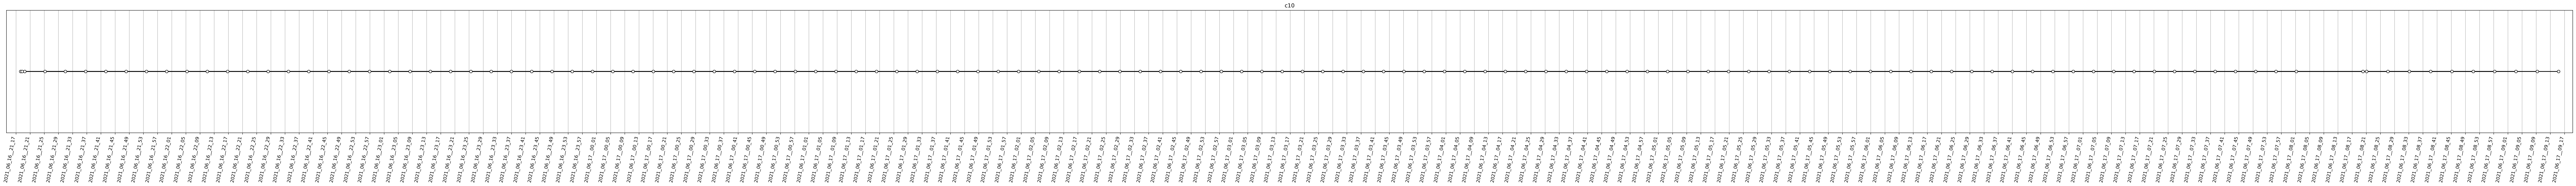

In [93]:
plot_annnotations_timestamps(annotation['c10'], title='c10')

Start date: 2021-03-25 16:18:36
End date: 2021-04-29 08:47:09


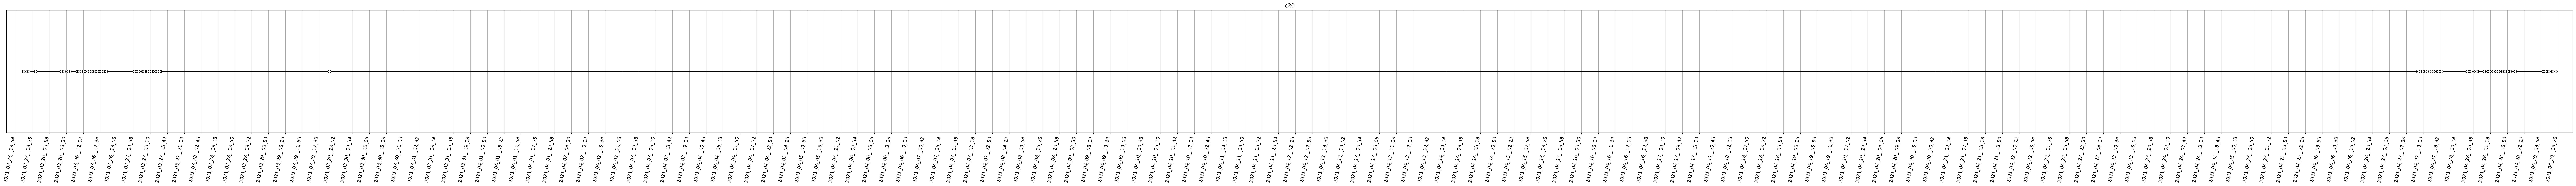

In [94]:
plot_annnotations_timestamps(annotation['c20'], title='c20')

Start date: 2021-03-25 16:17:55
End date: 2021-04-27 13:58:54


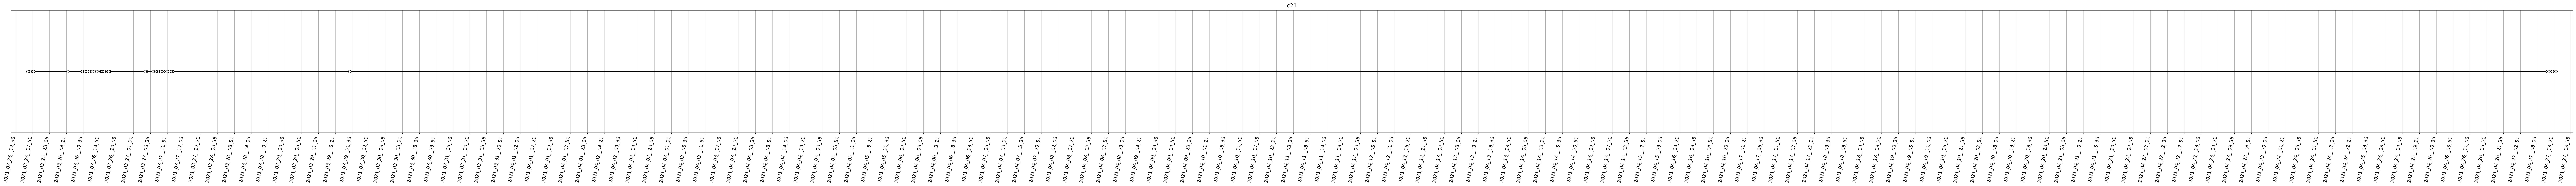

In [95]:
plot_annnotations_timestamps(annotation['c21'], title='c21')

Start date: 2021-03-25 17:17:58.329000
End date: 2021-03-29 22:56:59.440000


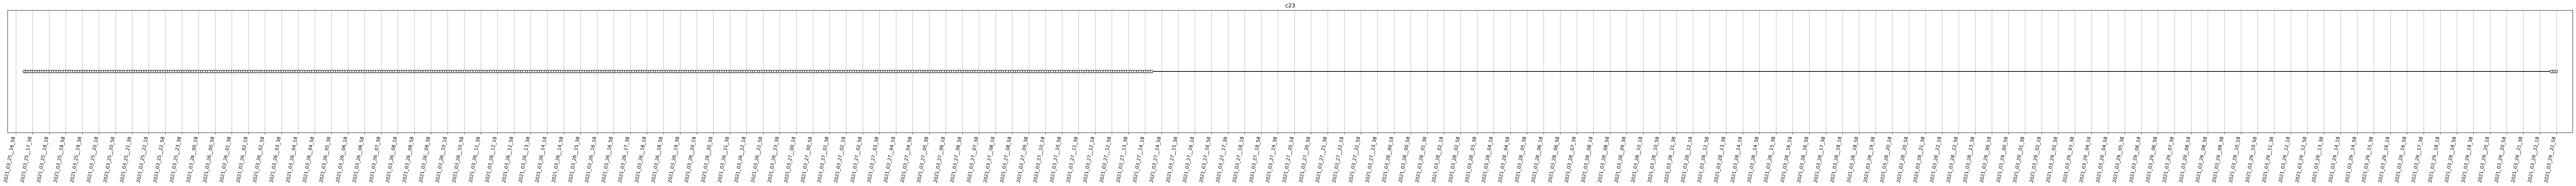

In [96]:
plot_annnotations_timestamps(annotation['c23'], title='c23')

In [3]:
%matplotlib inline

import sys
sys.path.insert(1, './..')

import random
import itertools
import cv2
import os
from remove_similar_frames import preprocess_imgs
from thirdrdparty.imaging_interview import compare_frames_change_detection
from functools import partial
import matplotlib.pyplot as plt
import numpy as np


def preprocess_function(img):
    return preprocess_imgs([img])[0]


images_cache = {}

def load_images_cached(img_name, root_directory, cache, preprocess_func):
    if img_name not in cache:
        img = cv2.imread(os.path.join(root_directory, img_name), cv2.IMREAD_COLOR)
        cache[img_name] = preprocess_func(img)

    return cache[img_name]


def load_image(img_name, root_directory):
    img = cv2.imread(os.path.join(root_directory, img_name), cv2.IMREAD_COLOR)

    return img

def generate_img_pairs_names(dataset, num_pairs_each_seq):
    imgs_pairs_names = []
    for _, annotations in dataset.items():
        imgs_pairs = random.choices(list(itertools.combinations(range(len(annotations)), 2)), k=num_pairs_each_seq)
        names = [[annotations[img_index].image_name for img_index in i] for i in imgs_pairs]
        imgs_pairs_names.extend(names)

    return imgs_pairs_names

num_sampled = 1000

imgs_pairs_names = generate_img_pairs_names(annotation, num_sampled)

In [8]:
with open('sampled_pairs.txt', 'w') as f:
    f.writelines([' '.join(p) + '\n' for p in imgs_pairs_names])

In [7]:
imgs_pairs_names[0]

['c23-1616757858714.png', 'c23-1616702748470.png']

In [82]:
gblur_half_size_ratio=0.0075
min_contour_area_ratio = 0.0125

In [23]:
def load_preprocess_compare(images_names_pair, dataset_dir, gb_ks_r, mca_r):
    assert len(images_names_pair) == 2
    imgs = list(map(partial(load_image, root_directory=dataset_dir), images_names_pair))
    imgs = preprocess_imgs(imgs, gblur_half_size_ratio=gb_ks_r)

    score_nonnormed, contours, thresholded_diff = compare_frames_change_detection(imgs[0], imgs[1], 
                                                                                  np.prod(imgs[0].shape)*mca_r)
    score = score_nonnormed
    if len(contours) != 0:
        score = score_nonnormed / np.prod(imgs[0].shape)

    return score, contours, thresholded_diff

['c23-1616757858714.png', 'c23-1616702748470.png']
['c23-1616832493926.png', 'c23-1616811955408.png']
['c23-1616716432163.png', 'c23-1616716774165.png']
['c23-1616764710745.png', 'c23-1616787665582.png']
['c23-1616822216566.png', 'c23-1616757516433.png']
['c23-1616814349057.png', 'c23-1616843111673.png']
['c23-1616711986543.png', 'c23-1616719852540.png']
['c23-1616743809978.png', 'c23-1616789720272.png']
['c23-1616830780876.png', 'c23-1616772250108.png']
['c23-1616730112747.png', 'c23-1616840371625.png']
['c23-1616716090208.png', 'c23-1616706171160.png']
['c23-1616844139469.png', 'c23-1616713354869.png']
['c23-1616712670907.png', 'c23-1616699666493.png']
['c23-1616835577086.png', 'c23-1616789377672.png']
['c23-1616809902599.png', 'c23-1616698639412.png']
['c23-1616776018960.png', 'c23-1616690419647.png']
['c23-1616759229080.png', 'c23-1616797588141.png']
['c23-1616834892048.png', 'c23-1616700351574.png']
['c23-1616809902599.png', 'c23-1616763683024.png']
['c23-1616781844990.png', 'c23-

Text(0.5, 1.0, 'gb_ks: 0.0075; min_ca: 0.0125')

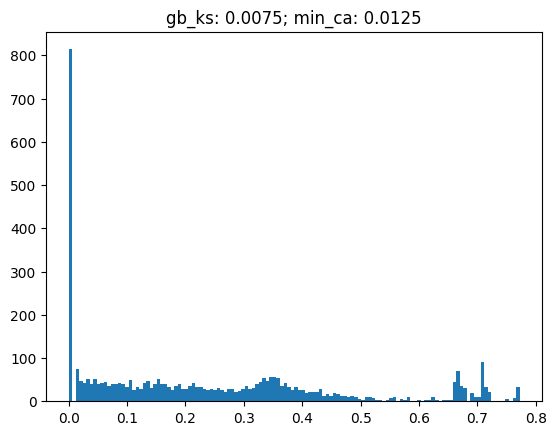

In [83]:
scores = []
thresholded_diffs = []

for p in imgs_pairs_names:
    print(p)

    # imgs = list(map(partial(load_image, root_directory=DATASET_ROOT_DIR), p))

    # imgs = preprocess_imgs(imgs, gblur_half_size_ratio=gblur_half_size_ratio)

    # score_nonnormed, contours, thresholded_diff = compare_frames_change_detection(imgs[0], imgs[1], np.prod(imgs[0].shape)*min_contour_area_ratio)

    # score = score_nonnormed
    # if len(contours) != 0:
    #     score = score_nonnormed / np.prod(imgs[0].shape)
    score, _, thresholded_diff = load_preprocess_compare(p, DATASET_ROOT_DIR, gblur_half_size_ratio, min_contour_area_ratio)

    scores.append(score)
    thresholded_diffs.append(thresholded_diff)

plt.hist(scores, bins=128)
plt.title(f'gb_ks: {gblur_half_size_ratio}; min_ca: {min_contour_area_ratio}')

(0.0, 0.02)

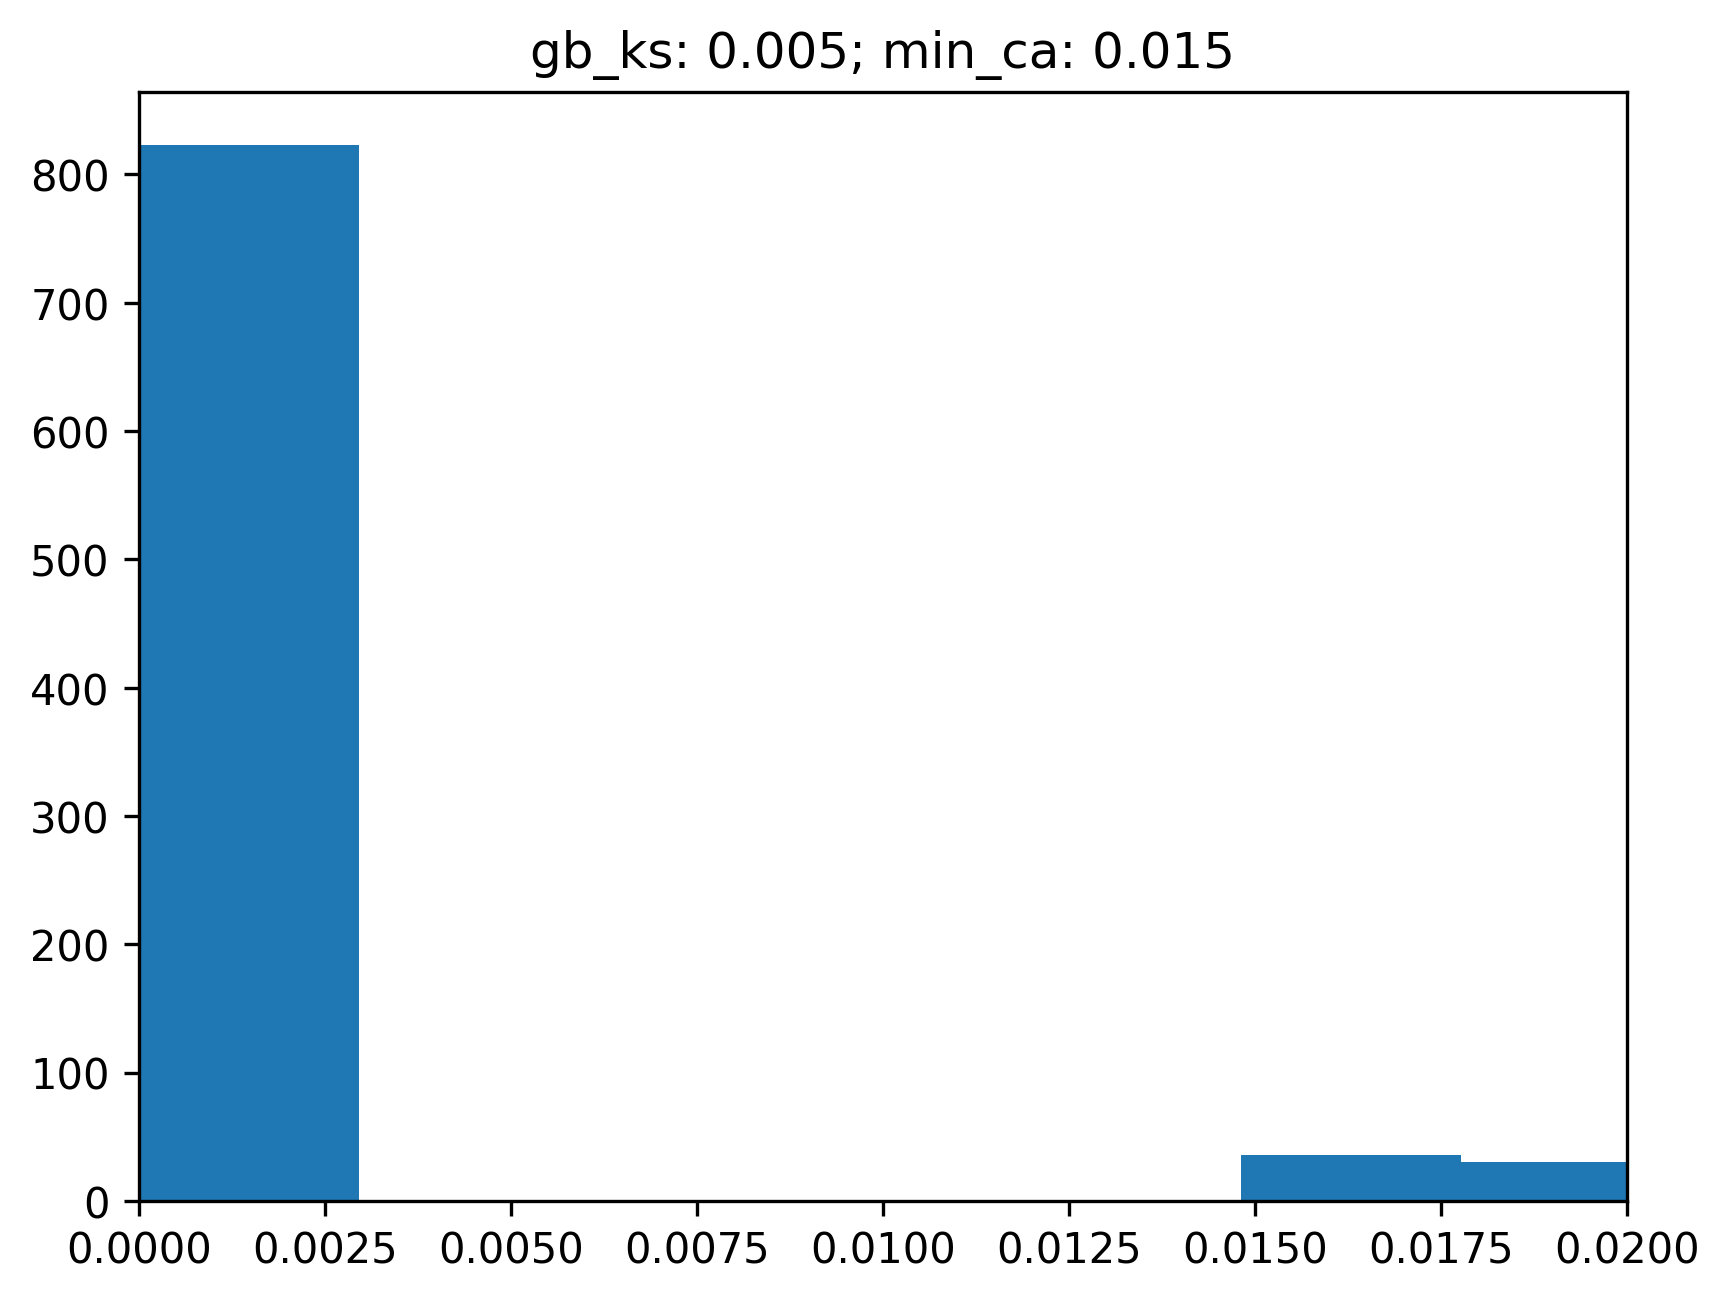

In [97]:
plt.hist(scores, bins=256)
plt.title(f'gb_ks: {gblur_half_size_ratio}; min_ca: {min_contour_area_ratio}')
plt.gcf().set_dpi(300)
# plt.xticks(np.arange(0, max(scores), 0.05))
plt.xlim(0, 0.02)

In [84]:
def generate_match_res_img(img_names, thr_diff, gblur_ks_r, dataset_dir):
    orig_imgs = list(map(partial(load_image, root_directory=dataset_dir), img_names))

    preprocessed_imgs = preprocess_imgs(orig_imgs, gblur_half_size_ratio=gblur_ks_r)
    
    orig_imgs = [cv2.resize(i, preprocessed_imgs[0].shape[::-1]) for i in orig_imgs]

    preprocessed_imgs = [cv2.cvtColor(i, cv2.COLOR_GRAY2BGR) for i in preprocessed_imgs]

    imgs_to_save = np.vstack([np.hstack(orig_imgs), np.hstack(preprocessed_imgs)])

    thr_diff = cv2.cvtColor(thr_diff, cv2.COLOR_GRAY2BGR)
    thr_diff = cv2.resize(thr_diff, [imgs_to_save.shape[1], imgs_to_save.shape[1] * thr_diff.shape[0] // thr_diff.shape[1]])
    
    imgs_to_save = np.vstack([imgs_to_save, thr_diff])

    return imgs_to_save


scores_imgs_pairs_diff = zip(scores, imgs_pairs_names, thresholded_diffs)

save_results_dir = f'results_gb_ks_{gblur_half_size_ratio}_min_ca_{min_contour_area_ratio}'
os.makedirs(save_results_dir, exist_ok=True)


for score_pair in sorted(scores_imgs_pairs_diff, key=lambda e: e[0])[::10]:
    (score, img_names, thr_diff) = score_pair

    img = generate_match_res_img(img_names, thr_diff, gblur_half_size_ratio, DATASET_ROOT_DIR)

    cv2.imwrite(os.path.join(save_results_dir, f'{score:.6f}={"=".join(img_names)}=.png'), 
                img)

In [33]:
list(filter(lambda x: 'c10-1623897642421' in x[1][0] and 'c10-1623897298581' in x[1][1], enumerate(imgs_pairs_names)))

[(3835, ['c10-1623897642421.png', 'c10-1623897298581.png'])]

In [34]:
scores[3835]

0.013470052083333333

In [13]:
chosen_samples_pairs_dir = 'samples_no_filtering'

chosen_img_pairs_names = []

for fname in sorted(os.listdir(chosen_samples_pairs_dir)):
    splits = fname.split('.png_')
    chosen_img_pairs_names.append((splits[0].split('_', 1)[1], splits[1]))

In [14]:
chosen_img_pairs_names

[('c10-1623897642421', 'c10-1623897298581'),
 ('c10-1623901080202', 'c10-1623903829982'),
 ('c20_2021_03_26__10_21_25', 'c20_2021_03_26__10_49_59'),
 ('c23-1616734217166', 'c23-1616817769833'),
 ('c23-1616795535932', 'c23-1617050734758'),
 ('c21_2021_03_26__12_15_39', 'c21_2021_03_26__13_12_45'),
 ('c23-1616745522905', 'c23-1616751004843'),
 ('c23-1616783214920', 'c23-1616714722717'),
 ('c20_2021_04_27__11_58_54', 'c20_2021_04_27__11_47_19'),
 ('c10-1623871512458', 'c10-1623901423986'),
 ('c21_2021_04_27__13_07_29', 'c21_2021_04_27__13_24_38'),
 ('c21_2021_03_26__16_44_04', 'c21_2021_03_26__16_26_56'),
 ('c20_2021_04_27__12_04_37', 'c20_2021_04_27__13_01_45'),
 ('c21_2021_03_27__10_42_18', 'c21_2021_03_26__10_55_43'),
 ('c21_2021_03_26__11_41_23', 'c21_2021_03_27__09_10_59'),
 ('c21_2021_03_26__12_44_12', 'c21_2021_03_27__10_13_46'),
 ('c21_2021_03_27__11_39_24', 'c21_2021_03_26__11_29_58')]

In [15]:
significantly_different_pairs = {('c23-1616795535932', 'c23-1617050734758'), 
                                 ('c20_2021_04_27__11_58_54', 'c20_2021_04_27__11_47_19'),
                                 ('c21_2021_04_27__13_07_29', 'c21_2021_04_27__13_24_38'),
                                 ('c21_2021_03_26__16_44_04', 'c21_2021_03_26__16_26_56'),
                                 ('c20_2021_04_27__12_04_37', 'c20_2021_04_27__13_01_45'),
                                }

In [21]:
np.logspace(-6, -3, num=50)

array([1.00000000e-06, 1.15139540e-06, 1.32571137e-06, 1.52641797e-06,
       1.75751062e-06, 2.02358965e-06, 2.32995181e-06, 2.68269580e-06,
       3.08884360e-06, 3.55648031e-06, 4.09491506e-06, 4.71486636e-06,
       5.42867544e-06, 6.25055193e-06, 7.19685673e-06, 8.28642773e-06,
       9.54095476e-06, 1.09854114e-05, 1.26485522e-05, 1.45634848e-05,
       1.67683294e-05, 1.93069773e-05, 2.22299648e-05, 2.55954792e-05,
       2.94705170e-05, 3.39322177e-05, 3.90693994e-05, 4.49843267e-05,
       5.17947468e-05, 5.96362332e-05, 6.86648845e-05, 7.90604321e-05,
       9.10298178e-05, 1.04811313e-04, 1.20679264e-04, 1.38949549e-04,
       1.59985872e-04, 1.84206997e-04, 2.12095089e-04, 2.44205309e-04,
       2.81176870e-04, 3.23745754e-04, 3.72759372e-04, 4.29193426e-04,
       4.94171336e-04, 5.68986603e-04, 6.55128557e-04, 7.54312006e-04,
       8.68511374e-04, 1.00000000e-03])

In [65]:
import importlib
# importlib.reload(from remove_preprocess_imgs)
import remove_similar_frames
importlib.reload(remove_similar_frames)
from remove_similar_frames import preprocess_imgs

In [66]:
from collections import defaultdict

scores_data_gb = defaultdict(list)

gaussian_blur_ks_r = [0.0] + np.logspace(-2.7, -1, num=50).tolist()

for gb_ks_r in gaussian_blur_ks_r:
    for p in chosen_img_pairs_names:
        score, _, _ = load_preprocess_compare([i_name + '.png' for i_name in p], DATASET_ROOT_DIR, gb_ks_r, 0.0)
        scores_data_gb[p].append(score)

In [67]:
scores_data_gb

defaultdict(list,
            {('c10-1623897642421', 'c10-1623897298581'): [0.013470052083333333,
              0.00010416666666666667,
              0.00010416666666666667,
              0.00010416666666666667,
              0.00010416666666666667,
              0.00010416666666666667,
              0.00010416666666666667,
              0.00010416666666666667,
              0.00010416666666666667,
              0.00010416666666666667,
              0.00010416666666666667,
              0,
              0,
              0,
              0,
              0,
              0,
              0,
              0,
              0,
              0,
              0,
              0,
              0,
              0,
              0,
              0,
              0,
              0,
              0,
              0,
              0,
              0,
              0,
              0,
              0,
              0,
              0,
              0,
              0,
              0,
            

('c23-1616795535932', 'c23-1617050734758') 0.047657214506172836
('c20_2021_04_27__11_58_54', 'c20_2021_04_27__11_47_19') 0.13295476466049383
('c21_2021_04_27__13_07_29', 'c21_2021_04_27__13_24_38') 0.15900294174382715
('c21_2021_03_26__16_44_04', 'c21_2021_03_26__16_26_56') 0.16377387152777778
('c20_2021_04_27__12_04_37', 'c20_2021_04_27__13_01_45') 0.16851731288580246


(0.0, 0.02)

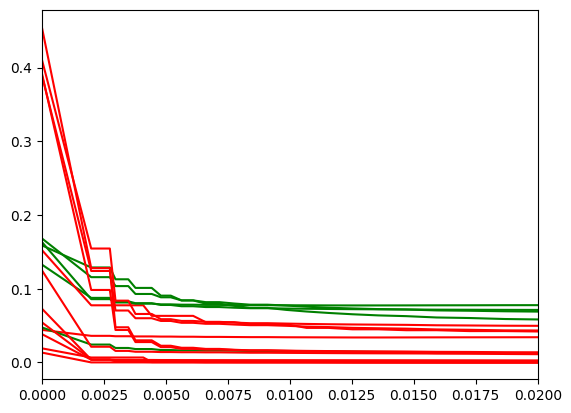

In [77]:
%matplotlib inline

for img_names_pair, scores in scores_data_gb.items():
    plt.plot(gaussian_blur_ks_r, scores, color='green' if img_names_pair in significantly_different_pairs else 'red')
    if img_names_pair in significantly_different_pairs:
        print(img_names_pair, scores[0])

# plt.xscale('log')
# plt.xticks(gaussian_blur_ks_r)
plt.xlim(0, 0.02)

In [78]:
from collections import defaultdict

scores_data_mca = defaultdict(list)

mca_ratio_values = [0.0] + np.logspace(-8, -1, num=50).tolist()

for mca_val in mca_ratio_values:
    for p in chosen_img_pairs_names:
        score, _, _ = load_preprocess_compare([i_name + '.png' for i_name in p], DATASET_ROOT_DIR, 0.0075, mca_val)
        scores_data_mca[p].append(score)

('c23-1616795535932', 'c23-1617050734758') 0.01597511574074074
('c20_2021_04_27__11_58_54', 'c20_2021_04_27__11_47_19') 0.07431495949074074
('c21_2021_04_27__13_07_29', 'c21_2021_04_27__13_24_38') 0.07683714313271604
('c21_2021_03_26__16_44_04', 'c21_2021_03_26__16_26_56') 0.07785807291666667
('c20_2021_04_27__12_04_37', 'c20_2021_04_27__13_01_45') 0.07998987268518519


(0.0, 0.02)

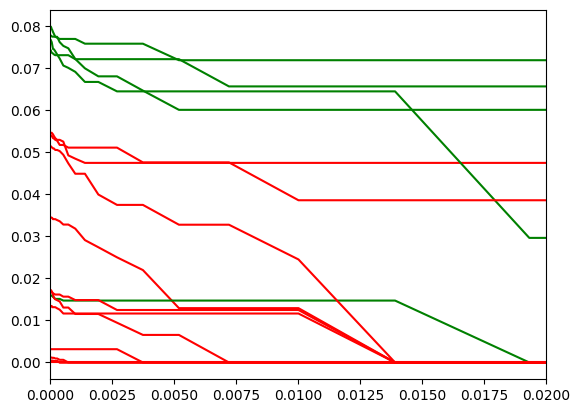

In [81]:
%matplotlib inline

for img_names_pair, scores in scores_data_mca.items():
    plt.plot(mca_ratio_values, scores, color='green' if img_names_pair in significantly_different_pairs else 'red')
    if img_names_pair in significantly_different_pairs:
        print(img_names_pair, scores[0])

# plt.xscale('log')
plt.xlim(0, 0.02)

In [10]:
from sklearn.cluster import DBSCAN
import numpy as np

X = np.array([[1, 2], [2, 2], [2, 3],
              [8, 7], [8, 8], [25, 80]])

Y = np.asarray(list(range(len(X)))).reshape((-1, 1))

print(Y)

def metric(a, b):
    return np.linalg.norm(X[int(a.item())] - X[int(b.item())])


clustering = DBSCAN(eps=3, min_samples=2, metric=metric).fit(Y)
clustering.labels_

# array([ 0,  0,  0,  1,  1, -1])

[[0]
 [1]
 [2]
 [3]
 [4]
 [5]]


array([ 0,  0,  0,  1,  1, -1])

In [103]:
import random
import itertools

random.choices(list(itertools.combinations(range(300), 2)), k=3)

[(197, 250), (157, 253), (78, 172)]

41


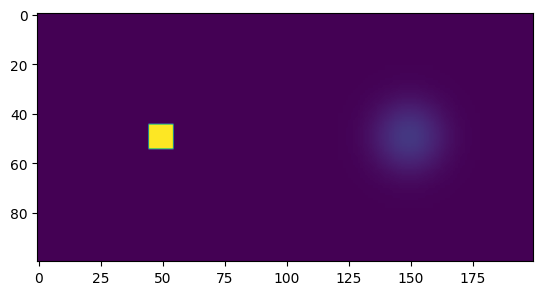

In [114]:
img = np.zeros((100, 100), dtype=np.uint8)

img[45:55, 45:55] = 255

img_res = cv2.GaussianBlur(img, [61, 61], 0)

plt.imshow(np.hstack([img, img_res]))

print(img_res[50, 50])

In [116]:
np.zeros((100, 200, 3)).shape[1::-1]

(200, 100)

In [121]:
from itertools import compress

list(compress([1, 2, 3, 4], [True, False, False, True]))

[1, 4]

In [136]:
import importlib
# importlib.reload(from remove_preprocess_imgs)
import remove_similar_frames
importlib.reload(remove_similar_frames)
from remove_similar_frames import create_annotation

full_annotation = create_annotation(DATASET_ROOT_DIR)

In [182]:
import importlib
# importlib.reload(from remove_preprocess_imgs)
import remove_similar_frames
importlib.reload(remove_similar_frames)
from remove_similar_frames import remove_subsequent_similar_frames, create_caching_load_preprocess, \
    get_min_area_img_size, remove_similar_frames_by_clustering

gblur_halfsize_ratio=0.0075
min_cnt_area_ratio = 0.0125
score_thr = 0.01

load_prep_func = create_caching_load_preprocess()
img_size = get_min_area_img_size(full_annotation['c23'])

subseq_unique_samples = remove_subsequent_similar_frames(full_annotation['c23'], DATASET_ROOT_DIR, 
                                                         img_size, load_prep_func, gblur_halfsize_ratio, 
                                                         min_cnt_area_ratio, score_thr)

unique_frames = remove_similar_frames_by_clustering(subseq_unique_samples, DATASET_ROOT_DIR, img_size, load_prep_func, 
                                    gblur_halfsize_ratio, min_cnt_area_ratio, score_thr)

In [183]:
import shutil

copy_unique_frames_dir = 'unique'

os.makedirs(copy_unique_frames_dir, exist_ok=True)

for frame in unique_frames:
    shutil.copy2(os.path.join(DATASET_ROOT_DIR, frame.image_name), os.path.join(copy_unique_frames_dir, frame.image_name))

In [ ]:
import importlib
# importlib.reload(from remove_preprocess_imgs)
import remove_similar_frames
importlib.reload(remove_similar_frames)
from remove_similar_frames import SimilarImagesRemover

rr = SimilarImagesRemover(gblur_halfsize_ratio, min_cnt_area_ratio, score_thr, None, 300)

rr.process_directory(copy_unique_frames_dir)

In [143]:
print(len(subseq_unique_samples))
list(sorted(subseq_unique_samples, key=lambda s: s.image_name))

15


[FrameAnnotation(image_name='c10-1623871098865.png', epoch_timestamp_ms=1623871098865, hr_timestamp='2021_06_16__21_18_18', orig_img_size_wh=(2688, 1520)),
 FrameAnnotation(image_name='c10-1623872544167.png', epoch_timestamp_ms=1623872544167, hr_timestamp='2021_06_16__21_42_24', orig_img_size_wh=(640, 480)),
 FrameAnnotation(image_name='c10-1623898673581.png', epoch_timestamp_ms=1623898673581, hr_timestamp='2021_06_17__04_57_53', orig_img_size_wh=(640, 480)),
 FrameAnnotation(image_name='c10-1623904517473.png', epoch_timestamp_ms=1623904517473, hr_timestamp='2021_06_17__06_35_17', orig_img_size_wh=(640, 480)),
 FrameAnnotation(image_name='c10-1623904861138.png', epoch_timestamp_ms=1623904861138, hr_timestamp='2021_06_17__06_41_01', orig_img_size_wh=(640, 480)),
 FrameAnnotation(image_name='c10-1623905204852.png', epoch_timestamp_ms=1623905204852, hr_timestamp='2021_06_17__06_46_44', orig_img_size_wh=(640, 480)),
 FrameAnnotation(image_name='c10-1623905548701.png', epoch_timestamp_ms=16

0

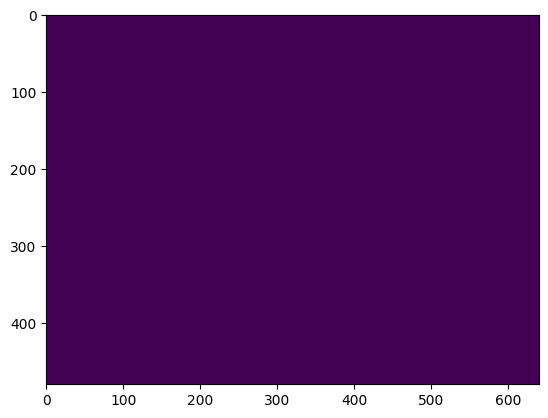

In [159]:
metric(np.asarray(0), np.asarray(2))

In [162]:
from sklearn.cluster import DBSCAN
import numpy as np
from remove_similar_frames import compare_imgs

Y = np.asarray(list(range(len(subseq_unique_samples)))).reshape((-1, 1))

# print(Y)

def metric(a, b):
    sample_1 = subseq_unique_samples[int(a.item())]
    sample_2 = subseq_unique_samples[int(b.item())]
    print(sample_1.image_name, sample_2.image_name)
    
    img1 = load_prep_func(sample_1.image_name, DATASET_ROOT_DIR, img_size, gblur_halfsize_ratio)
    img2 = load_prep_func(sample_2.image_name, DATASET_ROOT_DIR, img_size, gblur_halfsize_ratio)

    similarity, _, thr = compare_imgs(img1, img2, min_cnt_area_ratio)

    # plt.imshow(thr)
    
    return similarity


In [168]:
clustering = DBSCAN(eps=score_thr, min_samples=1, metric=metric).fit(Y)

c10-1623905892576.png c10-1623871098865.png
c10-1623905892576.png c10-1623872544167.png
c10-1623905892576.png c10-1623898673581.png
c10-1623905892576.png c10-1623904517473.png
c10-1623905892576.png c10-1623904861138.png
c10-1623905892576.png c10-1623905204852.png
c10-1623905892576.png c10-1623905548701.png
c10-1623905892576.png c10-1623905892576.png
c10-1623905892576.png c10-1623906236331.png
c10-1623905892576.png c10-1623906579975.png
c10-1623905892576.png c10-1623906923570.png
c10-1623905892576.png c10-1623907267276.png
c10-1623905892576.png c10-1623907610882.png
c10-1623905892576.png c10-1623913758221.png
c10-1623905892576.png c10-1623914119849.png
c10-1623871098865.png c10-1623905892576.png
c10-1623871098865.png c10-1623871098865.png
c10-1623871098865.png c10-1623872544167.png
c10-1623871098865.png c10-1623898673581.png
c10-1623871098865.png c10-1623904517473.png
c10-1623871098865.png c10-1623904861138.png
c10-1623871098865.png c10-1623905204852.png
c10-1623871098865.png c10-162390

In [169]:
print(clustering.labels_)

[ 0  1  0  2  3  4  5  6  7  8  9 10 11 12 13]


In [171]:
subseq_unique_samples

[FrameAnnotation(image_name='c10-1623871098865.png', epoch_timestamp_ms=1623871098865, hr_timestamp='2021_06_16__21_18_18', orig_img_size_wh=(2688, 1520)),
 FrameAnnotation(image_name='c10-1623872544167.png', epoch_timestamp_ms=1623872544167, hr_timestamp='2021_06_16__21_42_24', orig_img_size_wh=(640, 480)),
 FrameAnnotation(image_name='c10-1623898673581.png', epoch_timestamp_ms=1623898673581, hr_timestamp='2021_06_17__04_57_53', orig_img_size_wh=(640, 480)),
 FrameAnnotation(image_name='c10-1623904517473.png', epoch_timestamp_ms=1623904517473, hr_timestamp='2021_06_17__06_35_17', orig_img_size_wh=(640, 480)),
 FrameAnnotation(image_name='c10-1623904861138.png', epoch_timestamp_ms=1623904861138, hr_timestamp='2021_06_17__06_41_01', orig_img_size_wh=(640, 480)),
 FrameAnnotation(image_name='c10-1623905204852.png', epoch_timestamp_ms=1623905204852, hr_timestamp='2021_06_17__06_46_44', orig_img_size_wh=(640, 480)),
 FrameAnnotation(image_name='c10-1623905548701.png', epoch_timestamp_ms=16

In [173]:
list(dict(zip(clustering.labels_, subseq_unique_samples)).values())

[FrameAnnotation(image_name='c10-1623898673581.png', epoch_timestamp_ms=1623898673581, hr_timestamp='2021_06_17__04_57_53', orig_img_size_wh=(640, 480)),
 FrameAnnotation(image_name='c10-1623872544167.png', epoch_timestamp_ms=1623872544167, hr_timestamp='2021_06_16__21_42_24', orig_img_size_wh=(640, 480)),
 FrameAnnotation(image_name='c10-1623904517473.png', epoch_timestamp_ms=1623904517473, hr_timestamp='2021_06_17__06_35_17', orig_img_size_wh=(640, 480)),
 FrameAnnotation(image_name='c10-1623904861138.png', epoch_timestamp_ms=1623904861138, hr_timestamp='2021_06_17__06_41_01', orig_img_size_wh=(640, 480)),
 FrameAnnotation(image_name='c10-1623905204852.png', epoch_timestamp_ms=1623905204852, hr_timestamp='2021_06_17__06_46_44', orig_img_size_wh=(640, 480)),
 FrameAnnotation(image_name='c10-1623905548701.png', epoch_timestamp_ms=1623905548701, hr_timestamp='2021_06_17__06_52_28', orig_img_size_wh=(640, 480)),
 FrameAnnotation(image_name='c10-1623905892576.png', epoch_timestamp_ms=1623

In [175]:
import importlib
# importlib.reload(from remove_preprocess_imgs)
import remove_similar_frames
importlib.reload(remove_similar_frames)
from remove_similar_frames import remove_similar_frames_by_clustering

remove_similar_frames_by_clustering(subseq_unique_samples, DATASET_ROOT_DIR, img_size, load_prep_func, 
                                    gblur_halfsize_ratio, min_cnt_area_ratio, score_thr)

[FrameAnnotation(image_name='c10-1623898673581.png', epoch_timestamp_ms=1623898673581, hr_timestamp='2021_06_17__04_57_53', orig_img_size_wh=(640, 480)),
 FrameAnnotation(image_name='c10-1623872544167.png', epoch_timestamp_ms=1623872544167, hr_timestamp='2021_06_16__21_42_24', orig_img_size_wh=(640, 480)),
 FrameAnnotation(image_name='c10-1623904517473.png', epoch_timestamp_ms=1623904517473, hr_timestamp='2021_06_17__06_35_17', orig_img_size_wh=(640, 480)),
 FrameAnnotation(image_name='c10-1623904861138.png', epoch_timestamp_ms=1623904861138, hr_timestamp='2021_06_17__06_41_01', orig_img_size_wh=(640, 480)),
 FrameAnnotation(image_name='c10-1623905204852.png', epoch_timestamp_ms=1623905204852, hr_timestamp='2021_06_17__06_46_44', orig_img_size_wh=(640, 480)),
 FrameAnnotation(image_name='c10-1623905548701.png', epoch_timestamp_ms=1623905548701, hr_timestamp='2021_06_17__06_52_28', orig_img_size_wh=(640, 480)),
 FrameAnnotation(image_name='c10-1623905892576.png', epoch_timestamp_ms=1623